# Making imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Alex-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Alex-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Alex-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Visualizing and exploring the data

In [2]:
train_data = pd.read_csv("data/train.csv")
val_data = pd.read_csv("data/val.csv")
test_data = pd.read_csv("data/test.csv")

In [3]:
def plot_scores_histogram(scores):
    plt.figure(figsize=(8, 6))
    plt.hist(scores, bins=int((scores.max() - scores.min()) / 0.25), edgecolor='black', color='skyblue')
    plt.title("Histogram of Train Data Scores", fontsize=16)
    plt.xlabel("Score", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Training data length is 24000
       id                                               text     score
0  196112  A sandwich and french bread sit on a cutting b... -0.666667
1  514558  A baseball player is standing on the field whi...  0.000000
2   54244  A casserole served at a restaurant in a brown ...  1.333333
3    9420    OLD BLACK AND WHITE PHOTO OF AN ALL BOYS SCHOOL  1.666667
4  531512    A woman is milking a cow in the animal stable.   0.250000


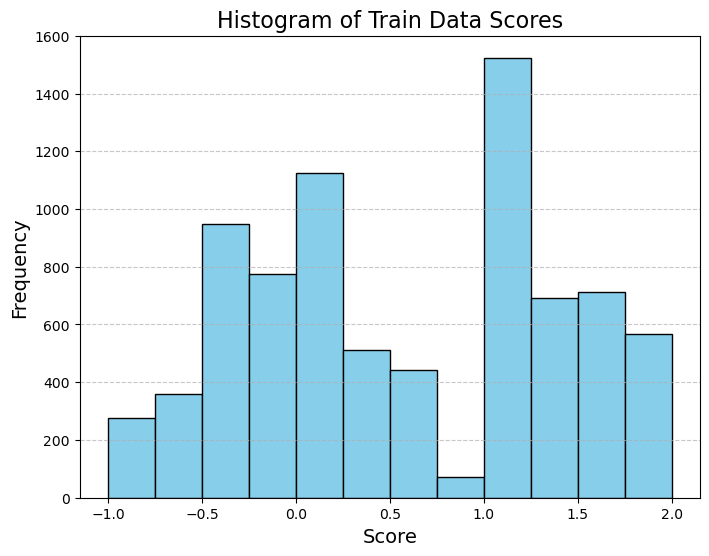

In [4]:
print(f"Training data length is {train_data.size}")
print(train_data.head()) 
plot_scores_histogram(train_data["score"])

       id                                               text     score
0  227928     A surfer on his surfboard performing a move.   -0.250000
1  438306    a passenger train going down a track by a fence  1.566667
2   34827  A open refrigerator door reveals that it is we...  1.250000
3  486397           A woman leads two sheep down the street. -0.833333
4  328203  A baseball player running towards base while t...  0.000000


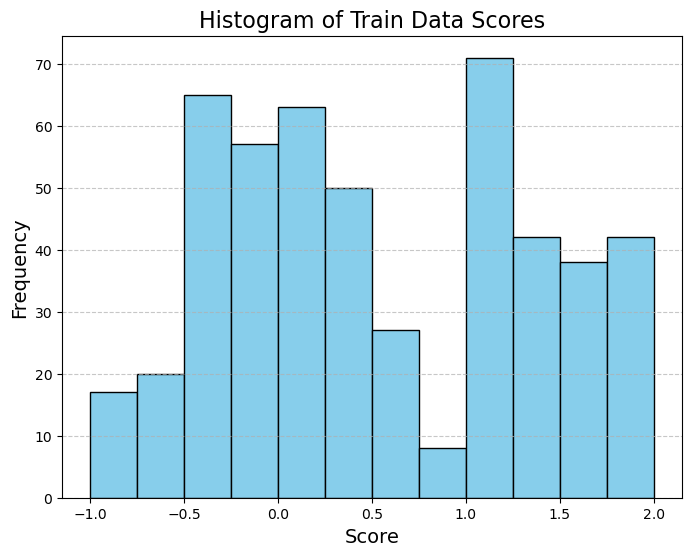

In [5]:
print(val_data.head()) 
plot_scores_histogram(val_data["score"])

In [6]:
test_data.head()

,id,text
0,456197,A large building with a clock tower surrounded...
1,138368,A woman hitting a tennis ball with a tennis ra...
2,63856,Skaters are skateboarding at the park while a ...
3,308947,Several firetrucks and firefighters are parked...
4,57992,Two black horses running on a hill with trees ...


# Split data and preprocess it

In [7]:
train_texts, train_scores = train_data["text"], train_data["score"]
val_texts, val_scores = val_data["text"], val_data["score"]

In [8]:
test_texts = test_data["text"]
test_ids = test_data["id"]

In [9]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

In [10]:
train_texts_processed = [preprocess_text(text) for text in train_texts]
val_texts_processed = [preprocess_text(text) for text in val_texts]

In [11]:
print(train_texts[0])
print(train_texts_processed[0])

A sandwich and french bread sit on a cutting board with an apple.
sandwich french bread sit cutting board apple


In [62]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Load Spacy model for NER
nlp = spacy.load("en_core_web_sm")

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Function to preprocess text
def preprocess_text_with_features(text):
    # Tokenize and POS tagging
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    
    # Generate POS tags
    pos_tags = pos_tag(tokens)
    pos_features = [f"{word}_{tag}" for word, tag in pos_tags]

    # Named entity recognition
    doc = nlp(" ".join(tokens))
    ner_features = [f"{ent.text}_{ent.label_}" for ent in doc.ents]
    
    # Combine tokens, POS, and NER features
    combined_features = tokens + pos_features + ner_features
    return " ".join(combined_features)

# Apply preprocessing to train and validation texts
train_texts_processed = [preprocess_text_with_features(text) for text in train_texts]
val_texts_processed = [preprocess_text_with_features(text) for text in val_texts]

# Creating the model

In [46]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  
train_features = vectorizer.fit_transform(train_texts_processed).toarray()
val_features = vectorizer.transform(val_texts_processed).toarray()

## Support Vector Regression (SVR)

In [27]:
model = SVR(kernel="linear", C=0.1, epsilon=0.1)
model.fit(train_features, train_scores)

SVR(C=0.1, kernel='linear')

In [18]:
param_grid = {
    "C": [0.1, 1, 10],
    "epsilon": [0.01, 0.1, 1],
    "kernel": ["linear", "rbf"],
}

grid_search = GridSearchCV(SVR(), param_grid, scoring="neg_mean_squared_error", cv=3)
grid_search.fit(train_features, train_scores)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}


## Random forest

In [32]:
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(train_features, train_scores)

RandomForestRegressor(n_estimators=300, random_state=42)

## Ridge Regression

In [63]:
params = {
    'alpha': [0.001, 0.1, 1.0, 10, 20, 30, 40, 50, 60, 70, 100],
    'solver': ['auto', 'saga', 'lsqr']
}
grid_search = GridSearchCV(Ridge(), params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_features, train_scores)
grid_search.best_params_

D:\Programs\Anaconda\envs\pymc_uni\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programs\Anaconda\envs\pymc_uni\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programs\Anaconda\envs\pymc_uni\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programs\Anaconda\envs\pymc_uni\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programs\Anaconda\envs\pymc_uni\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'alpha': 1.0, 'solver': 'saga'}

In [81]:
model = Ridge(alpha=6.0, solver='lsqr')  
model.fit(train_features, train_scores)

Ridge(alpha=6.0, solver='lsqr')

## Lasso Regression

In [93]:
params = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 20, 30, 40, 50, 60, 70, 100]
}
grid_search = GridSearchCV(Lasso(max_iter=10000), params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_features, train_scores)
grid_search.best_params_

{'alpha': 0.0001}

In [101]:
model = Lasso(alpha=0.0005, max_iter=10000, random_state=42) 
model.fit(train_features, train_scores)

Lasso(alpha=0.0005, max_iter=10000, random_state=42)

## Combining the models

In [121]:
# Ridge model predictions
ridge_model = Ridge(alpha=11.0, solver='lsqr') 
ridge_model.fit(train_features, train_scores)
ridge_preds = ridge_model.predict(val_features)

In [122]:
# Lasso model predictions
lasso_model = Lasso(alpha=0.0005, max_iter=10000, random_state=42) 
lasso_model.fit(train_features, train_scores)
lasso_preds = lasso_model.predict(val_features)

In [125]:
# Random Forest model predictions
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(train_features, train_scores)
rf_preds = rf_model.predict(val_features)

In [126]:
# Evaluate models using Spearman's rank correlation
ridge_score = spearmanr(val_scores, ridge_preds).correlation
lasso_score = spearmanr(val_scores, lasso_preds).correlation
rf_score = spearmanr(val_scores, rf_preds).correlation

print(f"Ridge: {ridge_score}, Lasso: {lasso_score}, Random Forest: {rf_score}")

total_score = ridge_score + lasso_score + rf_score
ridge_weight = ridge_score / total_score
lasso_weight = lasso_score / total_score
rf_weight = rf_score / total_score

print(f"Ridge Weight: {ridge_weight}, Lasso Weight: {lasso_weight}, RF Weight: {rf_weight}")

# Weighted average of predictions
final_preds = (ridge_weight * ridge_preds +
               lasso_weight * lasso_preds +
               rf_weight * rf_preds)

final_score = spearmanr(val_scores, final_preds).correlation
print(f"Combined Model Spearman Score: {final_score}")

Ridge: 0.6051163877012231, Lasso: 0.5707103375985584, Random Forest: 0.5858997956891087
Ridge Weight: 0.3434791839096342, Lasso Weight: 0.3239494500418873, RF Weight: 0.3325713660484785
Combined Model Spearman Score: 0.6058515804724648


In [72]:
base_models = [
    ('ridge', Ridge(alpha=11.0, solver='lsqr')),
    ('rf', RandomForestRegressor(n_estimators=100))
]
model = StackingRegressor(estimators=base_models, final_estimator=Ridge())
model.fit(train_features, train_scores)

KeyboardInterrupt: 

# Evaluating and testing the model

In [82]:
val_predictions = model.predict(val_features)

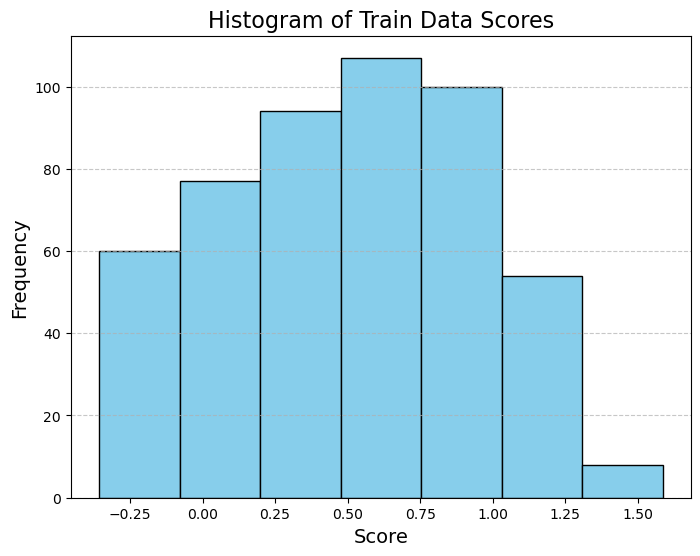

In [83]:
plot_scores_histogram(val_predictions)

In [84]:
mse = mean_squared_error(val_scores, val_predictions)
mae = mean_absolute_error(val_scores, val_predictions)
spearman_corr, _ = spearmanr(val_scores, val_predictions)

print(f"Validation MSE: {mse}")
print(f"Validation MAE: {mae}")
print(f"Spearman's Rank Correlation: {spearman_corr}")

Validation MSE: 0.42843682585029114
Validation MAE: 0.5276980392964483
Spearman's Rank Correlation: 0.6014439332331196


# Preparing test data

In [38]:
test_texts_processed = [preprocess_text(text) for text in test_texts]
test_features = vectorizer.transform(test_texts_processed).toarray()

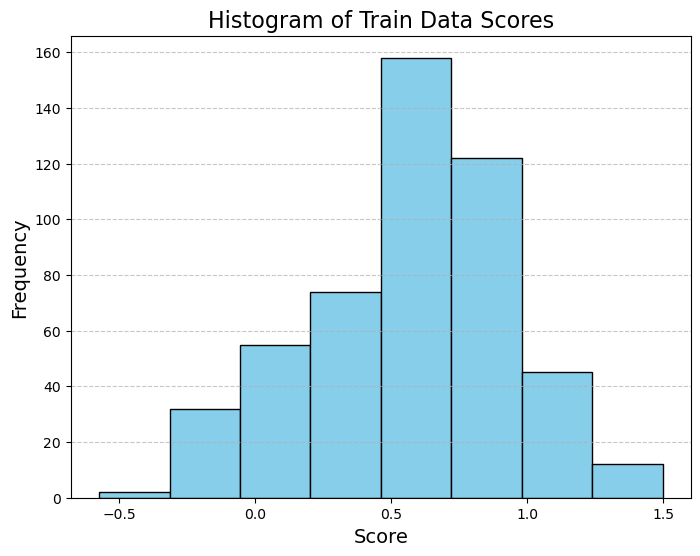

In [128]:
ridge_test_preds = ridge_model.predict(test_features)

lasso_test_preds = lasso_model.predict(test_features)

rf_test_preds = rf_model.predict(test_features)

test_predictions = (ridge_weight * ridge_test_preds +
               lasso_weight * lasso_test_preds +
               rf_weight * rf_test_preds)

plot_scores_histogram(test_predictions)

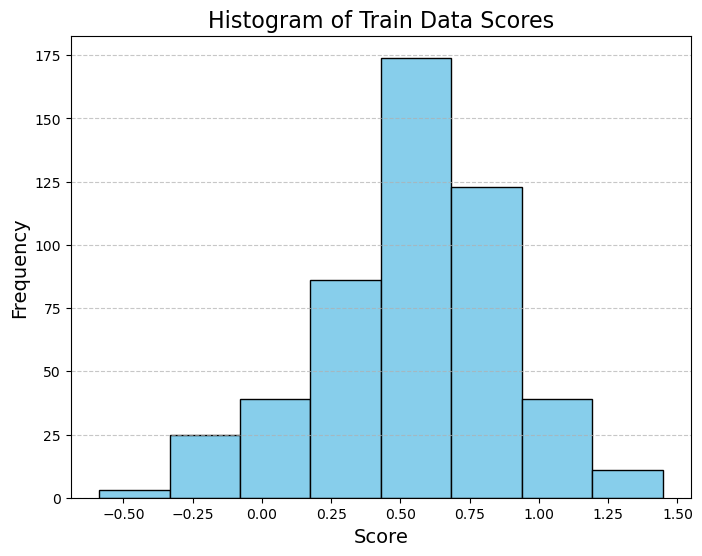

In [39]:
test_predictions = model.predict(test_features)
plot_scores_histogram(test_predictions)

In [40]:
output_df = pd.DataFrame({
    "id": np.array(test_ids).flatten(),
    "score": test_predictions.flatten()
})

output_df.to_csv("saves/submission_new_ridge2.csv", index=False)

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
from textblob import TextBlob

train_texts, train_scores = train_data["text"], train_data["score"]
val_texts, val_scores = val_data["text"], val_data["score"]

# Custom text preprocessing transformer
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        text = re.sub(r'http\S+', '', text)  # Remove URLs
        text = re.sub(r'\d+', '<NUM>', text)  # Replace numbers
        tokens = word_tokenize(text.lower())
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in self.stop_words]
        return ' '.join(tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([self.preprocess_text(text) for text in X])

# Custom feature augmenter
class FeatureAugmenter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for text in X:
            blob = TextBlob(text)
            features.append([
                len(text.split()),  # Word count
                len(text),  # Character count
                np.mean([len(word) for word in text.split()]) if len(text.split()) > 0 else 0,  # Avg word length
                len(blob.sentences),  # Sentence count
                blob.sentiment.polarity,  # Sentiment polarity
                blob.sentiment.subjectivity  # Sentiment subjectivity
            ])
        return np.array(features)

# Preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),  # Preprocess text
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), sublinear_tf=True))
])

# Feature union
feature_union = FeatureUnion([
    ('tfidf_features', preprocessing_pipeline),
    ('augmented_features', Pipeline([
        ('preprocessor', TextPreprocessor()),  # Reuse the text preprocessor
        ('augmenter', FeatureAugmenter())
    ]))
])

# Final pipeline
final_pipeline = Pipeline([
    ('features', feature_union),
    ('regressor', Ridge(alpha=5.0, solver='lsqr'))
])

# Fit the model
final_pipeline.fit(train_texts, train_scores)

# Evaluate on validation set
val_predictions = final_pipeline.predict(val_texts)

mse = mean_squared_error(val_scores, val_predictions)
mae = mean_absolute_error(val_scores, val_predictions)
spearman_corr, _ = spearmanr(val_scores, val_predictions)

print(f"Validation MSE: {mse}")
print(f"Validation MAE: {mae}")
print(f"Spearman's Rank Correlation: {spearman_corr}")


Validation MSE: 0.4233678694310636
Validation MAE: 0.5209396024340908
Spearman's Rank Correlation: 0.6091098790702846
